# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:wisig-oracle.run1",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "1-10",
                "1-12",
                "1-14",
                "1-16",
                "1-18",
                "1-19",
                "1-8",
                "10-11",
                "10-17",
                "10-4",
                "10-7",
                "11-1",
                "11-10",
                "11-19",
                "11-20",
                "11-4",
                "11-7",
                "12-19",
                "12-20",
                "12-7",
                "13-14",
                "13-18",
                "13-19",
                "13-20",
                "13-3",
                "13-7",
                "14-10",
                "14-11",
                "14-12",
                "14-13",
                "14-14",
                "14-19",
                "14-20",
                "14-7",
                "14-8",
                "14-9",
                "15-1",
                "15-19",
                "15-6",
                "16-1",
                "16-16",
                "16-19",
                "16-20",
                "17-10",
                "17-11",
                "18-1",
                "18-10",
                "18-11",
                "18-12",
                "18-13",
                "18-14",
                "18-15",
                "18-16",
                "18-17",
                "18-19",
                "18-2",
                "18-20",
                "18-4",
                "18-5",
                "18-7",
                "18-8",
                "18-9",
                "19-1",
                "19-10",
                "19-11",
                "19-12",
                "19-13",
                "19-14",
                "19-15",
                "19-19",
                "19-2",
                "19-20",
                "19-3",
                "19-4",
                "19-6",
                "19-7",
                "19-8",
                "19-9",
                "2-1",
                "2-13",
                "2-15",
                "2-3",
                "2-4",
                "2-5",
                "2-6",
                "2-7",
                "2-8",
                "20-1",
                "20-12",
                "20-14",
                "20-15",
                "20-16",
                "20-18",
                "20-19",
                "20-20",
                "20-3",
                "20-4",
                "20-5",
                "20-7",
                "20-8",
                "3-1",
                "3-13",
                "3-18",
                "3-2",
                "3-8",
                "4-1",
                "4-10",
                "4-11",
                "5-1",
                "5-5",
                "6-1",
                "6-15",
                "6-6",
                "7-10",
                "7-11",
                "7-12",
                "7-13",
                "7-14",
                "7-7",
                "7-8",
                "7-9",
                "8-1",
                "8-13",
                "8-14",
                "8-18",
                "8-20",
                "8-3",
                "8-8",
                "9-1",
                "9-7",
            ],
            "domains": [1, 2, 3, 4],
            "num_examples_per_domain_per_label": -1,
            "pickle_path": "/root/csc500-main/datasets/wisig.node3-19.stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "Wisig_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 10000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run138', 'ORACLE.run144', 'ORACLE.run126', 'ORACLE.run114', 'ORACLE.run120', 'ORACLE.run132', 'ORACLE.run150', 'ORACLE.run18'}


{'Wisig_1', 'Wisig_2', 'Wisig_3', 'Wisig_4'}


tensor([[[ 1.2104,  0.2177,  0.8969,  ..., -0.2699, -0.8185, -0.2612],
         [ 0.2786,  0.4093, -0.0348,  ...,  1.1146,  0.2264, -1.1320]],

        [[ 0.5840,  0.9276, -1.2969,  ..., -1.5889, -0.4896,  0.9018],
         [ 0.5239,  0.4810, -0.1460,  ..., -1.0478, -0.3693, -0.1975]],

        [[-0.7359, -0.1692,  0.6852,  ...,  0.1607, -0.2538, -0.1776],
         [ 0.4653,  0.5921,  0.7782,  ..., -0.2199,  0.7867, -1.1420]],

        ...,

        [[ 0.4953, -0.2030, -0.8931,  ..., -0.1055, -0.6739, -1.3234],
         [ 0.0487,  0.1543,  0.7794,  ...,  0.7470, -0.1137,  1.1367]],

        [[ 0.2961,  0.5757, -0.6086,  ...,  1.8504,  1.1596,  0.3948],
         [ 0.6579,  0.1892, -0.2714,  ...,  0.9129,  0.4194,  0.5428]],

        [[ 0.1823, -0.4915, -1.1098,  ..., -0.3171,  0.6341,  0.9512],
         [ 0.3884, -0.6738, -1.2762,  ...,  0.3250, -0.6817,  1.4031]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 33600], examples_per_second: 6.3410, train_label_loss: 2.7613, 


epoch: 1, [batch: 3360 / 33600], examples_per_second: 2926.1261, train_label_loss: 2.1320, 


epoch: 1, [batch: 6720 / 33600], examples_per_second: 3457.1941, train_label_loss: 0.9908, 


epoch: 1, [batch: 10080 / 33600], examples_per_second: 3563.3211, train_label_loss: 0.7218, 


epoch: 1, [batch: 13440 / 33600], examples_per_second: 3377.8617, train_label_loss: 1.1423, 


epoch: 1, [batch: 16800 / 33600], examples_per_second: 3485.4283, train_label_loss: 0.8631, 


epoch: 1, [batch: 20160 / 33600], examples_per_second: 3687.4346, train_label_loss: 0.5359, 


epoch: 1, [batch: 23520 / 33600], examples_per_second: 3365.0336, train_label_loss: 0.5527, 


epoch: 1, [batch: 26880 / 33600], examples_per_second: 3709.2435, train_label_loss: 0.5898, 


epoch: 1, [batch: 30240 / 33600], examples_per_second: 4273.9891, train_label_loss: 1.1973, 


epoch: 1, source_val_acc_label: 0.6339, target_val_acc_label: 0.6744, source_val_label_loss: 1.0059, target_val_label_loss: 5.5685, 


New best


epoch: 2, [batch: 1 / 33600], examples_per_second: 0.9997, train_label_loss: 0.7720, 


epoch: 2, [batch: 3360 / 33600], examples_per_second: 4166.1581, train_label_loss: 0.5705, 


epoch: 2, [batch: 6720 / 33600], examples_per_second: 4264.0569, train_label_loss: 1.4233, 


epoch: 2, [batch: 10080 / 33600], examples_per_second: 4412.6090, train_label_loss: 0.6232, 


epoch: 2, [batch: 13440 / 33600], examples_per_second: 3529.2384, train_label_loss: 0.3940, 


epoch: 2, [batch: 16800 / 33600], examples_per_second: 3673.5805, train_label_loss: 0.7859, 


epoch: 2, [batch: 20160 / 33600], examples_per_second: 3856.0827, train_label_loss: 1.2219, 


epoch: 2, [batch: 23520 / 33600], examples_per_second: 3829.6094, train_label_loss: 1.0894, 


epoch: 2, [batch: 26880 / 33600], examples_per_second: 3883.9519, train_label_loss: 1.1593, 


epoch: 2, [batch: 30240 / 33600], examples_per_second: 3880.9495, train_label_loss: 1.2221, 


epoch: 2, source_val_acc_label: 0.6778, target_val_acc_label: 0.6837, source_val_label_loss: 0.8534, target_val_label_loss: 7.0811, 


New best


epoch: 3, [batch: 1 / 33600], examples_per_second: 0.7521, train_label_loss: 0.7720, 


epoch: 3, [batch: 3360 / 33600], examples_per_second: 2897.0922, train_label_loss: 1.2191, 


epoch: 3, [batch: 6720 / 33600], examples_per_second: 3169.0203, train_label_loss: 1.2487, 


epoch: 3, [batch: 10080 / 33600], examples_per_second: 3481.7134, train_label_loss: 0.7126, 


epoch: 3, [batch: 13440 / 33600], examples_per_second: 3013.1972, train_label_loss: 0.6169, 


epoch: 3, [batch: 16800 / 33600], examples_per_second: 2962.8620, train_label_loss: 0.7192, 


epoch: 3, [batch: 20160 / 33600], examples_per_second: 2950.3616, train_label_loss: 1.0849, 


epoch: 3, [batch: 23520 / 33600], examples_per_second: 2964.9489, train_label_loss: 1.0106, 


epoch: 3, [batch: 26880 / 33600], examples_per_second: 3134.3227, train_label_loss: 1.1272, 


epoch: 3, [batch: 30240 / 33600], examples_per_second: 3461.5290, train_label_loss: 0.6369, 


epoch: 3, source_val_acc_label: 0.6932, target_val_acc_label: 0.7155, source_val_label_loss: 0.8255, target_val_label_loss: 7.8425, 


New best


epoch: 4, [batch: 1 / 33600], examples_per_second: 0.7486, train_label_loss: 0.4095, 


epoch: 4, [batch: 3360 / 33600], examples_per_second: 2968.6714, train_label_loss: 0.6124, 


epoch: 4, [batch: 6720 / 33600], examples_per_second: 3279.6059, train_label_loss: 1.1526, 


epoch: 4, [batch: 10080 / 33600], examples_per_second: 3598.0785, train_label_loss: 0.7946, 


epoch: 4, [batch: 13440 / 33600], examples_per_second: 3002.7102, train_label_loss: 0.5963, 


epoch: 4, [batch: 16800 / 33600], examples_per_second: 2975.8850, train_label_loss: 1.1664, 


epoch: 4, [batch: 20160 / 33600], examples_per_second: 2980.6376, train_label_loss: 1.1026, 


epoch: 4, [batch: 23520 / 33600], examples_per_second: 2978.2680, train_label_loss: 0.3476, 


epoch: 4, [batch: 26880 / 33600], examples_per_second: 3141.2783, train_label_loss: 0.5197, 


epoch: 4, [batch: 30240 / 33600], examples_per_second: 3449.1374, train_label_loss: 0.6981, 


epoch: 4, source_val_acc_label: 0.7090, target_val_acc_label: 0.7229, source_val_label_loss: 0.7846, target_val_label_loss: 7.9787, 


New best


epoch: 5, [batch: 1 / 33600], examples_per_second: 0.7427, train_label_loss: 0.4831, 


epoch: 5, [batch: 3360 / 33600], examples_per_second: 2965.9604, train_label_loss: 0.9055, 


epoch: 5, [batch: 6720 / 33600], examples_per_second: 3276.9157, train_label_loss: 0.7045, 


epoch: 5, [batch: 10080 / 33600], examples_per_second: 3565.4233, train_label_loss: 0.5280, 


epoch: 5, [batch: 13440 / 33600], examples_per_second: 2965.1254, train_label_loss: 0.7341, 


epoch: 5, [batch: 16800 / 33600], examples_per_second: 3010.4616, train_label_loss: 0.7582, 


epoch: 5, [batch: 20160 / 33600], examples_per_second: 2962.0773, train_label_loss: 0.5008, 


epoch: 5, [batch: 23520 / 33600], examples_per_second: 2966.5592, train_label_loss: 0.2121, 


epoch: 5, [batch: 26880 / 33600], examples_per_second: 3171.3808, train_label_loss: 0.5751, 


epoch: 5, [batch: 30240 / 33600], examples_per_second: 3504.1667, train_label_loss: 0.6666, 


epoch: 5, source_val_acc_label: 0.7239, target_val_acc_label: 0.7433, source_val_label_loss: 0.7525, target_val_label_loss: 8.7072, 


New best


epoch: 6, [batch: 1 / 33600], examples_per_second: 0.7448, train_label_loss: 0.4874, 


epoch: 6, [batch: 3360 / 33600], examples_per_second: 2971.8345, train_label_loss: 0.4362, 


epoch: 6, [batch: 6720 / 33600], examples_per_second: 3295.7633, train_label_loss: 0.6563, 


epoch: 6, [batch: 10080 / 33600], examples_per_second: 3607.6448, train_label_loss: 1.0377, 


epoch: 6, [batch: 13440 / 33600], examples_per_second: 2991.2992, train_label_loss: 0.5663, 


epoch: 6, [batch: 16800 / 33600], examples_per_second: 3001.4758, train_label_loss: 0.6659, 


epoch: 6, [batch: 20160 / 33600], examples_per_second: 2979.9939, train_label_loss: 0.6837, 


epoch: 6, [batch: 23520 / 33600], examples_per_second: 2971.9048, train_label_loss: 0.4522, 


epoch: 6, [batch: 26880 / 33600], examples_per_second: 3208.8975, train_label_loss: 0.5702, 


epoch: 6, [batch: 30240 / 33600], examples_per_second: 3550.5291, train_label_loss: 0.6979, 


epoch: 6, source_val_acc_label: 0.7314, target_val_acc_label: 0.7543, source_val_label_loss: 0.7430, target_val_label_loss: 8.9218, 


New best


epoch: 7, [batch: 1 / 33600], examples_per_second: 0.7408, train_label_loss: 0.6407, 


epoch: 7, [batch: 3360 / 33600], examples_per_second: 2955.0323, train_label_loss: 0.4597, 


epoch: 7, [batch: 6720 / 33600], examples_per_second: 3312.4176, train_label_loss: 0.4058, 


epoch: 7, [batch: 10080 / 33600], examples_per_second: 3521.8942, train_label_loss: 0.3578, 


epoch: 7, [batch: 13440 / 33600], examples_per_second: 2957.9410, train_label_loss: 0.2897, 


epoch: 7, [batch: 16800 / 33600], examples_per_second: 2969.9764, train_label_loss: 0.6570, 


epoch: 7, [batch: 20160 / 33600], examples_per_second: 2968.0410, train_label_loss: 0.3843, 


epoch: 7, [batch: 23520 / 33600], examples_per_second: 2969.0480, train_label_loss: 0.3675, 


epoch: 7, [batch: 26880 / 33600], examples_per_second: 3256.9726, train_label_loss: 0.3674, 


epoch: 7, [batch: 30240 / 33600], examples_per_second: 3584.1793, train_label_loss: 0.5324, 


epoch: 7, source_val_acc_label: 0.7304, target_val_acc_label: 0.7625, source_val_label_loss: 0.7383, target_val_label_loss: 8.8322, 


New best


epoch: 8, [batch: 1 / 33600], examples_per_second: 0.7372, train_label_loss: 0.2237, 


epoch: 8, [batch: 3360 / 33600], examples_per_second: 2950.3775, train_label_loss: 0.4023, 


epoch: 8, [batch: 6720 / 33600], examples_per_second: 3349.0642, train_label_loss: 0.3801, 


epoch: 8, [batch: 10080 / 33600], examples_per_second: 3471.3222, train_label_loss: 0.9058, 


epoch: 8, [batch: 13440 / 33600], examples_per_second: 2972.6714, train_label_loss: 0.7212, 


epoch: 8, [batch: 16800 / 33600], examples_per_second: 2976.8123, train_label_loss: 0.3433, 


epoch: 8, [batch: 20160 / 33600], examples_per_second: 2983.6658, train_label_loss: 0.5610, 


epoch: 8, [batch: 23520 / 33600], examples_per_second: 2965.9463, train_label_loss: 0.4409, 


epoch: 8, [batch: 26880 / 33600], examples_per_second: 3232.5114, train_label_loss: 0.5435, 


epoch: 8, [batch: 30240 / 33600], examples_per_second: 3421.2605, train_label_loss: 0.3278, 


epoch: 8, source_val_acc_label: 0.7305, target_val_acc_label: 0.7569, source_val_label_loss: 0.7579, target_val_label_loss: 9.9663, 


epoch: 9, [batch: 1 / 33600], examples_per_second: 0.8385, train_label_loss: 0.2651, 


epoch: 9, [batch: 3360 / 33600], examples_per_second: 3379.6059, train_label_loss: 0.3102, 


epoch: 9, [batch: 6720 / 33600], examples_per_second: 3778.8685, train_label_loss: 0.2932, 


epoch: 9, [batch: 10080 / 33600], examples_per_second: 4423.7824, train_label_loss: 0.6676, 


epoch: 9, [batch: 13440 / 33600], examples_per_second: 3862.4259, train_label_loss: 0.5930, 


epoch: 9, [batch: 16800 / 33600], examples_per_second: 3919.1971, train_label_loss: 0.4240, 


epoch: 9, [batch: 20160 / 33600], examples_per_second: 3861.2631, train_label_loss: 0.4313, 


epoch: 9, [batch: 23520 / 33600], examples_per_second: 3842.4758, train_label_loss: 0.4697, 


epoch: 9, [batch: 26880 / 33600], examples_per_second: 3875.1618, train_label_loss: 0.4465, 


epoch: 9, [batch: 30240 / 33600], examples_per_second: 3237.4110, train_label_loss: 0.3494, 


epoch: 9, source_val_acc_label: 0.7278, target_val_acc_label: 0.7654, source_val_label_loss: 0.7762, target_val_label_loss: 10.1021, 


New best


epoch: 10, [batch: 1 / 33600], examples_per_second: 0.7627, train_label_loss: 0.4275, 


epoch: 10, [batch: 3360 / 33600], examples_per_second: 3037.4596, train_label_loss: 0.3918, 


epoch: 10, [batch: 6720 / 33600], examples_per_second: 3442.8819, train_label_loss: 0.2813, 


epoch: 10, [batch: 10080 / 33600], examples_per_second: 3726.9050, train_label_loss: 0.5856, 


epoch: 10, [batch: 13440 / 33600], examples_per_second: 3157.5992, train_label_loss: 0.5063, 


epoch: 10, [batch: 16800 / 33600], examples_per_second: 2958.4512, train_label_loss: 0.5076, 


epoch: 10, [batch: 20160 / 33600], examples_per_second: 3239.8950, train_label_loss: 0.2473, 


epoch: 10, [batch: 23520 / 33600], examples_per_second: 3304.2816, train_label_loss: 0.1554, 


epoch: 10, [batch: 26880 / 33600], examples_per_second: 2975.5565, train_label_loss: 0.1637, 


epoch: 10, [batch: 30240 / 33600], examples_per_second: 3109.4491, train_label_loss: 0.5676, 


epoch: 10, source_val_acc_label: 0.7290, target_val_acc_label: 0.7668, source_val_label_loss: 0.7882, target_val_label_loss: 10.5705, 


New best


epoch: 11, [batch: 1 / 33600], examples_per_second: 0.7959, train_label_loss: 0.2644, 


epoch: 11, [batch: 3360 / 33600], examples_per_second: 3160.6096, train_label_loss: 0.2566, 


epoch: 11, [batch: 6720 / 33600], examples_per_second: 3676.4932, train_label_loss: 0.1723, 


epoch: 11, [batch: 10080 / 33600], examples_per_second: 3786.3136, train_label_loss: 0.3478, 


epoch: 11, [batch: 13440 / 33600], examples_per_second: 3408.8646, train_label_loss: 0.1927, 


epoch: 11, [batch: 16800 / 33600], examples_per_second: 3434.9327, train_label_loss: 0.4021, 


epoch: 11, [batch: 20160 / 33600], examples_per_second: 3408.2287, train_label_loss: 0.4815, 


epoch: 11, [batch: 23520 / 33600], examples_per_second: 3540.8340, train_label_loss: 0.3681, 


epoch: 11, [batch: 26880 / 33600], examples_per_second: 3934.9698, train_label_loss: 0.2516, 


epoch: 11, [batch: 30240 / 33600], examples_per_second: 3866.3509, train_label_loss: 0.8808, 


epoch: 11, source_val_acc_label: 0.7265, target_val_acc_label: 0.7712, source_val_label_loss: 0.8028, target_val_label_loss: 10.9801, 


New best


epoch: 12, [batch: 1 / 33600], examples_per_second: 0.9998, train_label_loss: 0.6324, 


epoch: 12, [batch: 3360 / 33600], examples_per_second: 3883.4726, train_label_loss: 0.2866, 


epoch: 12, [batch: 6720 / 33600], examples_per_second: 4375.1109, train_label_loss: 0.4069, 


epoch: 12, [batch: 10080 / 33600], examples_per_second: 3320.7362, train_label_loss: 0.2494, 


epoch: 12, [batch: 13440 / 33600], examples_per_second: 2921.4699, train_label_loss: 0.2193, 


epoch: 12, [batch: 16800 / 33600], examples_per_second: 3389.6333, train_label_loss: 0.4138, 


epoch: 12, [batch: 20160 / 33600], examples_per_second: 3163.1559, train_label_loss: 0.1131, 


epoch: 12, [batch: 23520 / 33600], examples_per_second: 2975.7935, train_label_loss: 0.1956, 


epoch: 12, [batch: 26880 / 33600], examples_per_second: 3224.8534, train_label_loss: 0.3343, 


epoch: 12, [batch: 30240 / 33600], examples_per_second: 3289.3394, train_label_loss: 0.2791, 


epoch: 12, source_val_acc_label: 0.7286, target_val_acc_label: 0.7683, source_val_label_loss: 0.8327, target_val_label_loss: 11.7348, 


epoch: 13, [batch: 1 / 33600], examples_per_second: 0.7486, train_label_loss: 0.3953, 


epoch: 13, [batch: 3360 / 33600], examples_per_second: 3237.3368, train_label_loss: 0.3780, 


epoch: 13, [batch: 6720 / 33600], examples_per_second: 3446.8458, train_label_loss: 0.3614, 


epoch: 13, [batch: 10080 / 33600], examples_per_second: 3567.9346, train_label_loss: 0.3812, 


epoch: 13, [batch: 13440 / 33600], examples_per_second: 3342.1766, train_label_loss: 0.3776, 


epoch: 13, [batch: 16800 / 33600], examples_per_second: 2993.0519, train_label_loss: 0.3272, 


epoch: 13, [batch: 20160 / 33600], examples_per_second: 3059.4682, train_label_loss: 0.3039, 


epoch: 13, [batch: 23520 / 33600], examples_per_second: 3383.7640, train_label_loss: 0.2492, 


epoch: 13, [batch: 26880 / 33600], examples_per_second: 3089.5280, train_label_loss: 0.5546, 


epoch: 13, [batch: 30240 / 33600], examples_per_second: 3001.3659, train_label_loss: 0.2352, 


epoch: 13, source_val_acc_label: 0.7249, target_val_acc_label: 0.7761, source_val_label_loss: 0.8436, target_val_label_loss: 11.7642, 


New best


epoch: 14, [batch: 1 / 33600], examples_per_second: 0.8231, train_label_loss: 0.3406, 


epoch: 14, [batch: 3360 / 33600], examples_per_second: 3544.4427, train_label_loss: 0.0952, 


epoch: 14, [batch: 6720 / 33600], examples_per_second: 3875.6925, train_label_loss: 0.2947, 


epoch: 14, [batch: 10080 / 33600], examples_per_second: 3526.3394, train_label_loss: 0.5279, 


epoch: 14, [batch: 13440 / 33600], examples_per_second: 3533.9670, train_label_loss: 0.1394, 


epoch: 14, [batch: 16800 / 33600], examples_per_second: 3937.3254, train_label_loss: 0.0889, 


epoch: 14, [batch: 20160 / 33600], examples_per_second: 3906.5428, train_label_loss: 0.3986, 


epoch: 14, [batch: 23520 / 33600], examples_per_second: 3930.9288, train_label_loss: 0.1558, 


epoch: 14, [batch: 26880 / 33600], examples_per_second: 3836.8743, train_label_loss: 0.1452, 


epoch: 14, [batch: 30240 / 33600], examples_per_second: 3206.4033, train_label_loss: 0.5416, 


epoch: 14, source_val_acc_label: 0.7218, target_val_acc_label: 0.7727, source_val_label_loss: 0.8757, target_val_label_loss: 12.3764, 


epoch: 15, [batch: 1 / 33600], examples_per_second: 0.7669, train_label_loss: 0.2584, 


epoch: 15, [batch: 3360 / 33600], examples_per_second: 3122.9842, train_label_loss: 0.6804, 


epoch: 15, [batch: 6720 / 33600], examples_per_second: 3576.8631, train_label_loss: 0.3423, 


epoch: 15, [batch: 10080 / 33600], examples_per_second: 3593.7017, train_label_loss: 0.3310, 


epoch: 15, [batch: 13440 / 33600], examples_per_second: 3151.5740, train_label_loss: 0.2175, 


epoch: 15, [batch: 16800 / 33600], examples_per_second: 3004.1975, train_label_loss: 0.3188, 


epoch: 15, [batch: 20160 / 33600], examples_per_second: 3286.1699, train_label_loss: 0.2151, 


epoch: 15, [batch: 23520 / 33600], examples_per_second: 3250.5894, train_label_loss: 0.3640, 


epoch: 15, [batch: 26880 / 33600], examples_per_second: 2998.5015, train_label_loss: 0.2345, 


epoch: 15, [batch: 30240 / 33600], examples_per_second: 3098.8868, train_label_loss: 0.1298, 


epoch: 15, source_val_acc_label: 0.7201, target_val_acc_label: 0.7716, source_val_label_loss: 0.8983, target_val_label_loss: 12.9317, 


epoch: 16, [batch: 1 / 33600], examples_per_second: 0.7803, train_label_loss: 0.3976, 


epoch: 16, [batch: 3360 / 33600], examples_per_second: 3223.3092, train_label_loss: 0.4798, 


epoch: 16, [batch: 6720 / 33600], examples_per_second: 3867.1258, train_label_loss: 0.0923, 


epoch: 16, [batch: 10080 / 33600], examples_per_second: 3514.0513, train_label_loss: 0.4359, 


epoch: 16, [batch: 13440 / 33600], examples_per_second: 3399.0026, train_label_loss: 0.1428, 


epoch: 16, [batch: 16800 / 33600], examples_per_second: 3383.8453, train_label_loss: 0.4699, 


epoch: 16, [batch: 20160 / 33600], examples_per_second: 3402.2801, train_label_loss: 0.0814, 


epoch: 16, [batch: 23520 / 33600], examples_per_second: 3618.3908, train_label_loss: 0.3105, 


epoch: 16, [batch: 26880 / 33600], examples_per_second: 3930.4665, train_label_loss: 0.2075, 


epoch: 16, [batch: 30240 / 33600], examples_per_second: 3946.5772, train_label_loss: 0.2952, 


epoch: 16, source_val_acc_label: 0.7187, target_val_acc_label: 0.7723, source_val_label_loss: 0.9262, target_val_label_loss: 13.1961, 


epoch: 17, [batch: 1 / 33600], examples_per_second: 0.9994, train_label_loss: 0.3715, 


epoch: 17, [batch: 3360 / 33600], examples_per_second: 4012.9315, train_label_loss: 0.3103, 


epoch: 17, [batch: 6720 / 33600], examples_per_second: 4632.2313, train_label_loss: 0.4299, 


epoch: 17, [batch: 10080 / 33600], examples_per_second: 3237.1975, train_label_loss: 0.3160, 


epoch: 17, [batch: 13440 / 33600], examples_per_second: 2962.1917, train_label_loss: 0.2990, 


epoch: 17, [batch: 16800 / 33600], examples_per_second: 2983.4993, train_label_loss: 0.1844, 


epoch: 17, [batch: 20160 / 33600], examples_per_second: 3005.8734, train_label_loss: 0.5545, 


epoch: 17, [batch: 23520 / 33600], examples_per_second: 2966.6103, train_label_loss: 0.1502, 


epoch: 17, [batch: 26880 / 33600], examples_per_second: 2960.1985, train_label_loss: 0.4134, 


epoch: 17, [batch: 30240 / 33600], examples_per_second: 2957.6625, train_label_loss: 0.2211, 


epoch: 17, source_val_acc_label: 0.7190, target_val_acc_label: 0.7765, source_val_label_loss: 0.9612, target_val_label_loss: 14.0650, 


New best


epoch: 18, [batch: 1 / 33600], examples_per_second: 0.7302, train_label_loss: 0.1200, 


epoch: 18, [batch: 3360 / 33600], examples_per_second: 3329.2633, train_label_loss: 0.1907, 


epoch: 18, [batch: 6720 / 33600], examples_per_second: 4046.5314, train_label_loss: 0.4137, 


epoch: 18, [batch: 10080 / 33600], examples_per_second: 3185.1242, train_label_loss: 0.2444, 


epoch: 18, [batch: 13440 / 33600], examples_per_second: 2937.3675, train_label_loss: 0.1097, 


epoch: 18, [batch: 16800 / 33600], examples_per_second: 2970.7474, train_label_loss: 0.0471, 


epoch: 18, [batch: 20160 / 33600], examples_per_second: 3005.2193, train_label_loss: 0.5618, 


epoch: 18, [batch: 23520 / 33600], examples_per_second: 3003.9832, train_label_loss: 0.2596, 


epoch: 18, [batch: 26880 / 33600], examples_per_second: 2995.3986, train_label_loss: 0.3383, 


epoch: 18, [batch: 30240 / 33600], examples_per_second: 2993.7192, train_label_loss: 0.2144, 


epoch: 18, source_val_acc_label: 0.7191, target_val_acc_label: 0.7720, source_val_label_loss: 0.9727, target_val_label_loss: 14.3826, 


epoch: 19, [batch: 1 / 33600], examples_per_second: 0.7338, train_label_loss: 0.3371, 


epoch: 19, [batch: 3360 / 33600], examples_per_second: 3343.4951, train_label_loss: 0.3608, 


epoch: 19, [batch: 6720 / 33600], examples_per_second: 4081.3414, train_label_loss: 0.0648, 


epoch: 19, [batch: 10080 / 33600], examples_per_second: 3097.3590, train_label_loss: 0.4134, 


epoch: 19, [batch: 13440 / 33600], examples_per_second: 2978.3691, train_label_loss: 0.5200, 


epoch: 19, [batch: 16800 / 33600], examples_per_second: 2991.4499, train_label_loss: 0.1095, 


epoch: 19, [batch: 20160 / 33600], examples_per_second: 2987.2169, train_label_loss: 0.2098, 


epoch: 19, [batch: 23520 / 33600], examples_per_second: 2954.2829, train_label_loss: 0.1099, 


epoch: 19, [batch: 26880 / 33600], examples_per_second: 2983.6784, train_label_loss: 0.2532, 


epoch: 19, [batch: 30240 / 33600], examples_per_second: 2996.8234, train_label_loss: 0.2246, 


epoch: 19, source_val_acc_label: 0.7102, target_val_acc_label: 0.7738, source_val_label_loss: 1.0066, target_val_label_loss: 14.4210, 


epoch: 20, [batch: 1 / 33600], examples_per_second: 0.7285, train_label_loss: 0.2371, 


epoch: 20, [batch: 3360 / 33600], examples_per_second: 3450.3060, train_label_loss: 0.3425, 


epoch: 20, [batch: 6720 / 33600], examples_per_second: 3927.3626, train_label_loss: 0.4780, 


epoch: 20, [batch: 10080 / 33600], examples_per_second: 3437.0963, train_label_loss: 0.3212, 


epoch: 20, [batch: 13440 / 33600], examples_per_second: 3390.8112, train_label_loss: 0.0328, 


epoch: 20, [batch: 16800 / 33600], examples_per_second: 3359.3646, train_label_loss: 0.1217, 


epoch: 20, [batch: 20160 / 33600], examples_per_second: 3362.7242, train_label_loss: 0.2881, 


epoch: 20, [batch: 23520 / 33600], examples_per_second: 3734.3953, train_label_loss: 0.0470, 


epoch: 20, [batch: 26880 / 33600], examples_per_second: 3920.2730, train_label_loss: 0.1698, 


epoch: 20, [batch: 30240 / 33600], examples_per_second: 3936.8368, train_label_loss: 0.1218, 


epoch: 20, source_val_acc_label: 0.7176, target_val_acc_label: 0.7741, source_val_label_loss: 1.0325, target_val_label_loss: 15.1940, 


epoch: 21, [batch: 1 / 33600], examples_per_second: 1.0026, train_label_loss: 0.0860, 


epoch: 21, [batch: 3360 / 33600], examples_per_second: 4003.6528, train_label_loss: 0.0407, 


epoch: 21, [batch: 6720 / 33600], examples_per_second: 4400.9429, train_label_loss: 0.3240, 


epoch: 21, [batch: 10080 / 33600], examples_per_second: 2966.4742, train_label_loss: 0.1138, 


epoch: 21, [batch: 13440 / 33600], examples_per_second: 2938.0370, train_label_loss: 0.2354, 


epoch: 21, [batch: 16800 / 33600], examples_per_second: 2936.7529, train_label_loss: 0.2473, 


epoch: 21, [batch: 20160 / 33600], examples_per_second: 2969.6564, train_label_loss: 0.2755, 


epoch: 21, [batch: 23520 / 33600], examples_per_second: 2980.1807, train_label_loss: 0.1734, 


epoch: 21, [batch: 26880 / 33600], examples_per_second: 3023.1787, train_label_loss: 0.2010, 


epoch: 21, [batch: 30240 / 33600], examples_per_second: 2985.0724, train_label_loss: 0.4979, 


epoch: 21, source_val_acc_label: 0.7123, target_val_acc_label: 0.7754, source_val_label_loss: 1.0471, target_val_label_loss: 15.1974, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

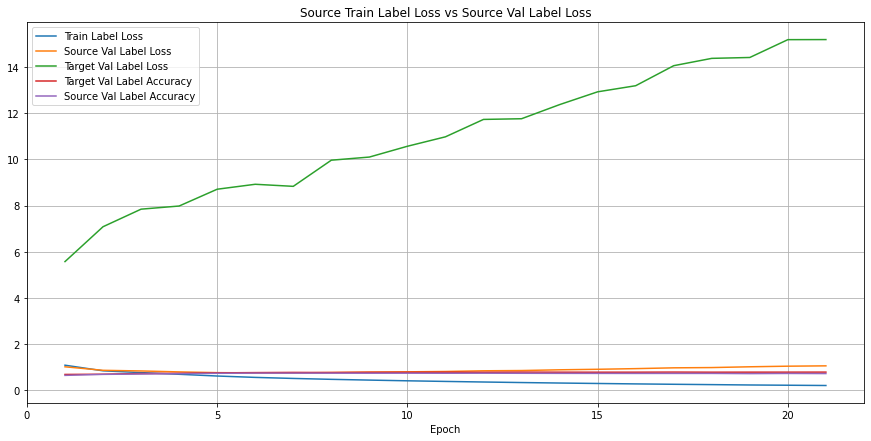

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

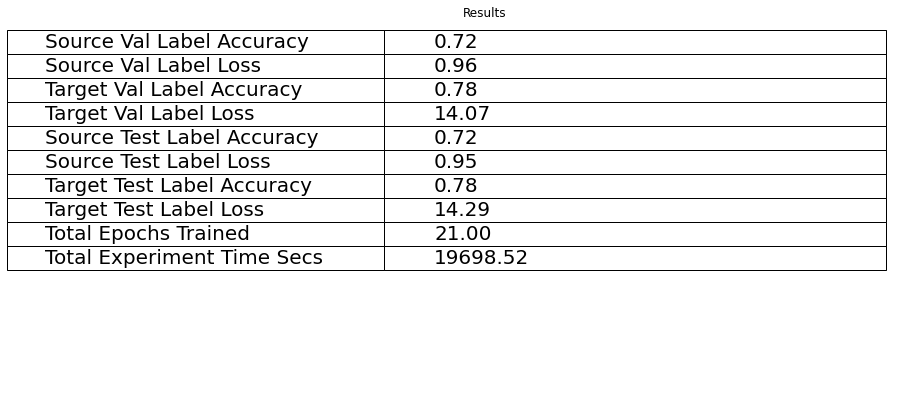

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

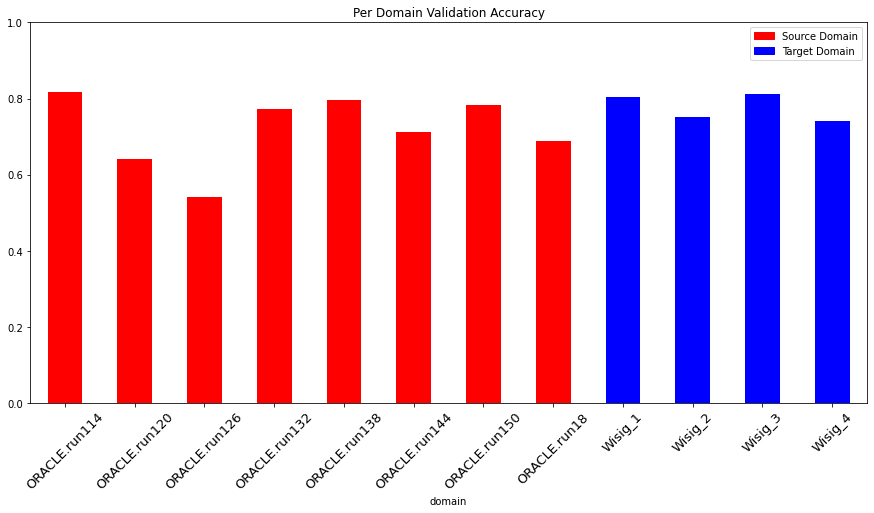

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7212760416666667 Target Test Label Accuracy: 0.7760577915376677
Source Val Label Accuracy: 0.7189973958333333 Target Val Label Accuracy: 0.7765311510031679


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:wisig-oracle.run1", "parameters": {"experiment_name": "tl_1v2:wisig-oracle.run1", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}}, {"class": "ReL